In [2]:
# pytorch imports
import numpy as np
import pandas as pd
import gc
import time

# common imports
from tqdm.notebook import tqdm
import os

# torch imports
import torch
import torch.nn.functional as F
import torch.nn as nn

# image transformations
import torchvision.transforms as transforms

# torch vision imports
from torchvision.models import vgg19,VGG19_Weights
from torch.utils.data import Dataset, DataLoader

# PIL imports and cv
from PIL import Image
import cv2 as cv

# matplotlib imports
import matplotlib.pyplot as plt

In [3]:
# Importing the files which we have made
from source.all_models import Generator, Discriminator
from source.all_losses import AnimeGanLoss, LossSummary
from source.anime_gan_dataset import AnimeDataSet
from source.vgg_feat import vgg19_features

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### trainer

In [41]:
class Trainer():

    def __init__(self, models, optimizers, anime_dataloader, optimizer_params, name, loss, img_feature, loss_tracker):

        # Initializing variables
        self.name = name
        self.anime_dataloader = anime_dataloader
        self.device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

        # loading generator and discriminator
        self.G = models['G'].to(self.device)
        self.D = models['D'].to(self.device)

        # generator optimizer, Discriminator optimizer
        self.G_optimizer = optimizers['G'](self.G.parameters(), **optimizer_params['G'])
        self.D_optimizer = optimizers['D'](self.D.parameters(), **optimizer_params['D'])
        self.init_optimizer = optimizers['init'](self.G.parameters(), **optimizer_params['init'])

        # feature extractor
        self.img_feat = img_feature
        
        # defining loss and loss tracker
        self.loss = loss
        self.loss_tracker = loss_tracker

        # reverse transform for transforming generated image to PIL image:
        self.reverse_transforms = transforms.Compose([
            transforms.Normalize(mean = -1, std = 1),
            transforms.Normalize(mean = 0, std = 2),
            transforms.ToPILImage(),
        ])
    
    def show_generated_image(self, image, save_path, name):

        # transformation to feed into generator
        image = transforms.Resize((512,512))(image)
        image = ( transforms.ToTensor()(image)*2 - 1 ).unsqueeze(0)

        # generating image
        generated_img = self.G(image.to(self.device)).squeeze()

        # saving the generated image
        image = self.reverse_transforms(generated_img)

        # creating the path
        os.makedirs(save_path, exist_ok = True)
        image.save(f'{save_path}/{name}.png')

        del generated_img, image, save_path
        gc.collect()
    
    def save_samples(self, save_dir, generator = None, loader = None, max_imgs=2, subname='gen'):
        '''
        Generate and save images
        '''
        generator = self.G if generator == None else generator
        loader = self.anime_dataloader if loader == None else loader

        G = generator.eval().to(self.device)

        # sampling images
        sample_indexes = np.random.randint(0,len(loader), size = min(len(loader),max_imgs))
        fake_imgs = []

        reverse_transforms = self.reverse_transforms

        for i, (img, *_) in enumerate(loader):
            # sampling image based on index
            if i in sample_indexes:
                
                with torch.no_grad():
                    fake_img = G(img[0].unsqueeze(0).to(self.device))
                    fake_img = fake_img.squeeze().detach()

                    # converting to the pil image
                    fake_img = reverse_transforms(fake_img)
                    fake_imgs.append(fake_img)
        
        # sample printing one image
        plt.imshow(fake_imgs[0])

        # creating a directory it is not there
        os.makedirs(save_dir, exist_ok=True)

        # saving the image
        for i,img in enumerate(fake_imgs):
            save_path = os.path.join(save_dir, f'{subname}_{i}.jpg')
            img.save(save_path)
        
        # to reduce memory usage
        del fake_imgs, fake_img, reverse_transforms, save_path, save_dir
        gc.collect()
    
    def data_iterator(self, data, print_image, args, only_content = False,):
            
            # losses for the generator
            epoch_color_loss = 0
            epoch_content_loss = 0
            epoch_style_loss = 0
            epoch_adv_G = 0

            # losses for the discriminator
            epoch_adv_D = 0

            # defining the loop obj
            loop_obj = tqdm(enumerate(data), total = len(data), position=0, leave=True)
            # loop_obj = enumerate(data)

            for index,batch in loop_obj:
                
                # setting the optimizers
                self.G_optimizer.zero_grad()
                self.D_optimizer.zero_grad()

                # getting the image and anime image
                image,anime_real, anime_gray, anime_smooth = batch

                # moving them to the cuda device
                image = image.to(self.device)
                anime_real = anime_real.to(self.device)
                anime_gray = anime_gray.to(self.device)
                anime_smooth = anime_smooth.to(self.device)

                # while training for first few iterations we only train with content loss
                if only_content:

                    # passing to model and getting the fake image
                    fake_image = self.G(image)

                    # getting the features of content image
                    content_feat = self.img_feat(image)[:3]
                    fake_feat = self.img_feat(fake_image)[:3]

                    # computing content loss
                    content_loss = self.loss.compute_content_loss(generator_image_content_features = fake_feat, original_image_content_features = content_feat)
                    epoch_content_loss += content_loss.item()

                    # updating the params
                    content_loss.backward()
                    self.init_optimizer.step()
                    # continue

                    # deleting to free memory
                    del fake_image
                    del content_feat
                    del fake_feat
                    del content_loss
                
                # training both discriminator and Generator
                else:

                    # ---------------- TRAIN D ---------------- #
                    self.D_optimizer.zero_grad()
                    fake_img = self.G(image).detach()

                    # Add some Gaussian noise to images before feeding to D
                    if args['d_noise']:
                        fake_img += self.gaussian_noise()
                        anime_real += self.gaussian_noise()
                        anime_gray += self.gaussian_noise()
                        anime_smooth += self.gaussian_noise()

                    # getting all the logits
                    fake_logits = self.D(fake_img)
                    anime_real_logits = self.D(anime_real)
                    anime_gray_logits = self.D(anime_gray)
                    anime_smooth_logits = self.D(anime_smooth)

                    # calculating the D loss
                    loss_d = self.loss.compute_discriminator_loss( generated_logits = fake_logits, anime_logits = anime_real_logits,
                                                                  anime_gray_logits = anime_gray_logits, anime_smooth_logits = anime_smooth_logits)

                    # optimizing D
                    loss_d = sum(loss_d)
                    loss_d.backward()
                    self.D_optimizer.step()

                    epoch_adv_D += loss_d.item()
                    
                    # updating the loss tracker
                    # self.loss_tracker.update_loss_D(loss_d)

                    # ---------------- TRAIN G ---------------- #
                    # print(f"training g")
                    self.G_optimizer.zero_grad()

                    # passing through discriminator and generator
                    fake_img = self.G(image)
                    fake_image_logits = self.D(fake_img)

                    # getting the features of the generated image and discriminator image and anime smooth image
                    content_feat = self.img_feat(image)[:3]
                    fake_feat = self.img_feat(fake_img)
                    style_feat = self.img_feat(anime_gray)[5:]

                    # calculating the Generator loss
                    col_loss, con_loss, style_loss, g_adv_loss = self.loss.compute_generator_loss(generated_image = fake_img, 
                               original_image = image, generated_image_logits = fake_image_logits,
                               generator_image_content_features = fake_feat[:3], original_image_content_features = content_feat, 
                               generator_style_feat = fake_feat[5:], anime_gray_style_feat = style_feat)
                    
                    # updating loss
                    epoch_color_loss += col_loss.item()
                    epoch_content_loss += con_loss.item()
                    epoch_style_loss += style_loss.item()
                    epoch_adv_G += g_adv_loss.item()

                    # adding loss
                    loss_g = g_adv_loss + con_loss + style_loss + col_loss

                    # optimizing g
                    loss_g.backward()
                    self.G_optimizer.step()

                    # tracking loss
                    # self.loss_tracker.update_loss_G(g_adv_loss, style_loss, col_loss, con_loss)

                    # updating all losses to the tqdm
                    avg_adv, avg_gram, avg_color, avg_content = epoch_adv_G/(index+1), epoch_style_loss/(index+1), epoch_color_loss/(index+1), epoch_content_loss/(index+1)# self.loss_tracker.avg_loss_G()
                    avg_adv_d = epoch_adv_D/(index+1) # self.loss_tracker.avg_loss_D()
                    loop_obj.set_description(f'loss D: (avg) {avg_adv_d:.2f} | loss G: adv {avg_adv:2f} | loss G: color {avg_color:2f} | loss G: content {avg_content:2f} | loss G: style {avg_gram:.2f}', refresh=True)

                    # deleting to free memory
                    del loss_g, loss_d, col_loss, con_loss, style_loss, g_adv_loss
                    del fake_image_logits, anime_gray_logits, anime_smooth_logits, anime_real_logits
                    del fake_img, image, avg_adv, avg_gram, avg_color, avg_content, avg_adv_d
                    del fake_feat, style_feat, content_feat
                    gc.collect()

                # printing the image and saving it every epoch
                if  print_image is not None and  ( (index + 1) % 10 == 0  or index == len(data) - 1):
                    self.show_generated_image(print_image['image'], print_image['save_dir'], print_image['name']+'_'+str(index))
            
            return [epoch_adv_D, epoch_adv_G, epoch_color_loss, epoch_content_loss, epoch_style_loss]
    
    def train_model(self, n_epochs = 10, init_epochs = 2, print_freq = 1, save_freq = 1, test_image_dict = {},
                    save_path_G = './Generator_weights/my_style/', save_path_D = './Discriminator_weights/my_style/',):
        
        # to store the losses and its performance
        train_loss_list = []

        # loop obj to get a track of the training progress
        loop_obj = range(n_epochs)

        # image for testing
        test_img = test_image_dict

        # ------------- Need to change ------------------
        for e in loop_obj:
            
            # training 
            test_img['name'] = str(e)
            losses = self.data_iterator(data = self.anime_dataloader, 
                                        print_image = test_img, 
                                        args = {'d_noise' : False}, 
                                        only_content =  init_epochs > e,)
            
            train_loss_list.append(losses)

            # training
            print(f"epoch {e} finished")

            # printing the data according to print freq
            if (e+1) % print_freq == 0:
               
               # printing losses
               print(f"epoch : {e+1} | loss D: (avg) {losses[0]:.2f} | loss G: adv {losses[1]:2f} | loss G: color {losses[2]:2f} | loss G: content {losses[3]:2f} | loss G: style {losses[4]:.2f} ")

               # saving samples
               self.save_samples(loader = self.anime_dataloader, generator = self.G, 
                                 save_dir = f'./training/random_generated_images/{self.name}/',
                                 subname = f'gen_{e}', max_imgs = 10)
            
            if (e+1) % save_freq == 0:
                # creating the paths
                os.makedirs(save_path_G, exist_ok=True)
                os.makedirs(save_path_D, exist_ok=True)
                # saving the image
                torch.save(self.G.state_dict(), os.path.join(save_path_G,f"{self.name}_{e}_G.pt") )
                torch.save(self.D.state_dict(), os.path.join(save_path_D,f"{self.name}_{e}_D.pt") )
            
            del losses
            gc.collect()
        
        return self.loss_tracker, train_loss_list

### Hyper params

In [6]:
## hyper params 

# models
G = Generator()
D = Discriminator()
feat = vgg19_features( layers = [4] )

# batch_size
batch_size = 2

# learning rates
G_optimizer_param = {'lr' : 2e-3}
D_optimizer_param  = {'lr' : 4e-3}
init_optimizer_param = {'lr' : 5e-3}

# init epochs
init_epochs = 0

# save,print freq
save_freq, print_freq = 1,1

# epochs
epochs = 10

In [7]:
print(f"Total trainable params in the generator model : {sum([p.numel() for p in G.parameters() if p.requires_grad])*1e-6:.3f}M")
print(f"Total trainable params in the discriminator model : {sum([p.numel() for p in D.parameters() if p.requires_grad])*1e-6:.3f}M")

Total trainable params in the generator model : 2.144M
Total trainable params in the discriminator model : 1.175M


In [47]:
## loss

class my_dictionary(dict):
 
    # __init__ function
    def __init__(self):
        self = dict()
         
    # Function to add key:value
    def add(self, key, value):
        self[key] = value

loss_args = my_dictionary()

# add arguments to loss args
loss_args.add('wadvg', 10.0)
loss_args.add('wadvd', 10.0)
loss_args.add('wcon', 1.5*2)
loss_args.add('wgra', 2.0)
loss_args.add('wcol', 65.0)
loss_args.add('gan_loss', 'lsgan')
loss_args.add('sharp', 0.2)
        
loss = AnimeGanLoss(device = device, args = loss_args)
loss_tracker = LossSummary()

In [9]:
## Dataset
dataset_args = my_dictionary()

# add arguments to loss args
dataset_args.add('data_dir', './dataset/dataset/')
dataset_args.add('dataset', 'bestpixels_/')
dataset_args.add('size', (256,256) )
dataset_args.add('train', 'train_photo')
dataset_args.add('required_length', 100)

anime_dataset = AnimeDataSet(dataset_args)
print('example :' , anime_dataset.anime_real_images_path[0])

example : ./dataset/dataset/bestpixels_/style\0.jpg


size of dataloader : 50


  0%|          | 0/50 [00:00<?, ?it/s]

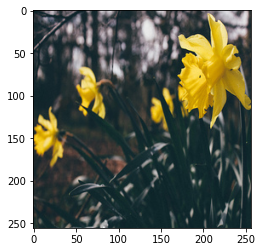

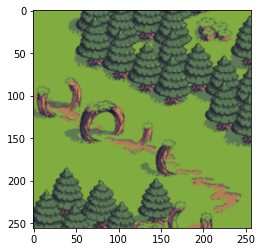

In [40]:
Anime_Dataloader  = DataLoader(anime_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

# example:
print(f"size of dataloader : {len(Anime_Dataloader)}")

shapes = []

for j,i in tqdm(enumerate(Anime_Dataloader), total = len(Anime_Dataloader)):
    # print( len(i))
    # if j % 100 == 0 : print(j , i[0].shape, i[1].shape, i[2].shape, i[3].shape)
    plt.imshow(transforms.ToPILImage()(i[0][0]*0.5 + 0.5) )
    plt.show()

    plt.imshow(transforms.ToPILImage()(i[1][1]*0.5 + 0.5) )
    plt.show()

    shapes.append(i[0].shape[-2:])
    break

### training

In [42]:
## Dataloader part
Anime_Dataloader = DataLoader(anime_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [28]:
# Freezing / loading weights inside the generator model

# loading
G.load_state_dict( torch.load('./Generator_weights/bestpixels_style/style_model_bestpixels_14_G.pt',map_location = device))
D.load_state_dict( torch.load('./Discriminator_weights/bestpixels_style/style_model_bestpixels_14_D.pt',map_location = device))

# G.load_state_dict( torch.load('./weights/paprika_new.pt'))

for p in G.parameters():
    p.requires_grad = False

# unfreezing all the normalization layers
for i,module in enumerate(G.modules()):
    # checking if the layer is a normalization layer
    if isinstance(module, (nn.BatchNorm2d, nn.GroupNorm, nn.InstanceNorm2d, nn.LazyBatchNorm2d)):
        # print(module)
        for p in module.parameters():
            p.requires_grad = True
            # print(p.shape)

for p in G.block_e.parameters():
    p.requires_grad = True

In [12]:
# for name,param in G.named_parameters():
#     print(f"Param name : {name} \t | requires_grad : {param.requires_grad}  \t | param size : {param.shape}")

In [29]:
print(f"Total trainable params in generator after freezing : {sum([p.numel() for p in G.parameters() if p.requires_grad])*1e-6:.3f}M")

Total trainable params in generator after freezing : 0.222M


In [48]:
# optimizers
optimizers = {'G' : torch.optim.Adam, 'D' : torch.optim.Adam, 'init' : torch.optim.Adam}
optimizer_params = {'G' : G_optimizer_param , 'D' : D_optimizer_param, 'init' : init_optimizer_param }

# dataloaders
Anime_Dataloader  = DataLoader(anime_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

# loss 
loss = AnimeGanLoss(device = device, args = loss_args)
loss_tracker = LossSummary()

# models
models = {'G' : G, 'D' : D}
feat = vgg19_features( layers = [0, 1, 2, 3, 4, 5, 6] )

In [49]:
Style_Trainer = Trainer(models = models, 
                        optimizers = optimizers, 
                        anime_dataloader = Anime_Dataloader, 
                        optimizer_params = optimizer_params, 
                        name = 'style_model_bestpixels', 
                        loss = loss, 
                        img_feature = feat, 
                        loss_tracker = loss_tracker)

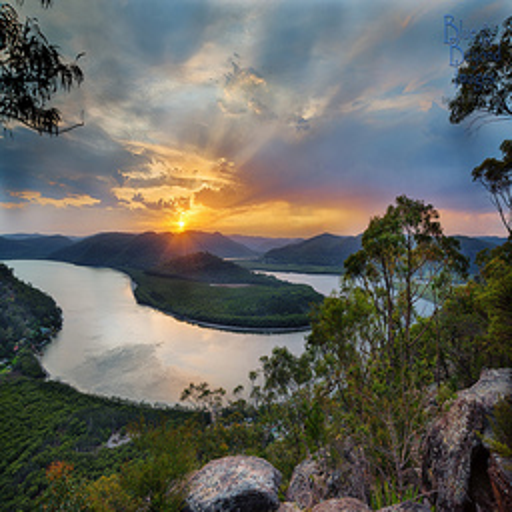

In [45]:
# test image
Image.open('./dataset/dataset/train_photo/2013-12-23 12_45_35.jpg').resize((512,512))

In [37]:
# Style_Trainer.save_samples(loader = None, generator = None, 
#                                  save_dir = f'./training/random_generated_samples/',
#                                  subname = f'gen_{0}', max_imgs = 10)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 0 finished
epoch : 1 | loss D: (avg) 552.86 | loss G: adv 311.802599 | loss G: color 166.676167 | loss G: content 189.207614 | loss G: style 313.60 


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1 finished
epoch : 2 | loss D: (avg) 342.87 | loss G: adv 246.339920 | loss G: color 157.219396 | loss G: content 180.739994 | loss G: style 315.90 


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 2 finished
epoch : 3 | loss D: (avg) 352.94 | loss G: adv 242.630471 | loss G: color 159.111107 | loss G: content 173.687466 | loss G: style 303.21 


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 3 finished
epoch : 4 | loss D: (avg) 341.94 | loss G: adv 242.086965 | loss G: color 134.733221 | loss G: content 161.171282 | loss G: style 289.03 


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

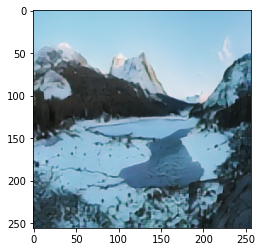

In [50]:
n_epochs = 10
init_epochs = 0
print_freq = 1
save_freq = 1
save_path_g = './Generator_weights/bestpixels_style/'
save_path_d = './Discriminator_weights/bestpixels_style/'
test_image_dict = {'image' : Image.open('./dataset/dataset/train_photo/2013-12-23 12_45_35.jpg') , 'save_dir' : f'./training/generator_test_results/' }

loss_history, history_list = Style_Trainer.train_model(n_epochs = n_epochs, 
                                                       init_epochs = init_epochs, 
                                                       print_freq = print_freq, 
                                                       save_freq = save_freq,
                                                       save_path_G = save_path_g, 
                                                       save_path_D = save_path_d,
                                                       test_image_dict = test_image_dict,)

In [53]:
for image in tqdm(os.listdir('./dataset/dataset/india_train/')[:30]):

    # getting the image path
    img_path = os.path.join('./dataset/dataset/india_train/', image)
    name = image[:-4]
    # print(name)
    Style_Trainer.show_generated_image(Image.open(img_path).convert('RGB'), './training/india_train_testing/bestpixels_style/', f'{name}')

  0%|          | 0/30 [00:00<?, ?it/s]